In [2]:
import re
import pandas as pd
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt, resample
from typing import Tuple
import matplotlib.pyplot as plt

from BedrettoDataset import BedrettoDataset
from phasenet import PhaseNet
import eval_utils 
import sys 
sys.path.append("..")
#from models.PhaseNet import PhaseNet

In [3]:
dataset = BedrettoDataset(csv_file='..//data//Bedretto_metadata.csv', h5_file='..//data//Bedretto_waveforms.hdf5', width=6000,tri_width = 30, allow_missing_s=True)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

torch.manual_seed(120)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10, persistent_workers=True)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    
model = PhaseNet().to(device)
#from models.PhaseNet import PhaseNet
#model = torch.load('../classification_tolga/phasenet_15epochs.pt').to(device)

epochs = 50
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [7]:
#epochs = 100
#model.to(device)

In [8]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        #p_only_mask = labels[:, 1, :].max(dim=1)[0] == 0
        #s_only_mask = labels[:, 0, :].max(dim=1)[0] == 0
        #both_mask = ~torch.logical_or(p_only_mask, s_only_mask)
        
        optimizer.zero_grad()
        outputs = model(inputs, logits=True) #inputs[:, 0, :]
        # Need to separate p_only, s_only, and both cases
        #loss = criterion(outputs[p_only_mask, 0, :], labels[p_only_mask, 0, :])
        #loss += criterion(outputs[s_only_mask, 1, :], labels[s_only_mask, 1, :])
        #loss += criterion(outputs[both_mask], labels[both_mask])
        #loss /= inputs.shape[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss += loss.cpu().detach().numpy() / inputs.shape[0]
            
        if (not i%10):
            pass
            #print(f"Iteration {i}/{len(train_loader)}, Loss: {train_loss / (i+1)}")  # print mean training loss so far

    if (epoch%10 == 9): 
        print(f"End of Epoch {epoch+1} mean training loss {train_loss / len(train_loader)}")
    
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, logits=True) #inputs[:, 0, :]
                #p_only_mask = labels[:, 1, :].max(dim=1)[0] == 0
                #s_only_mask = labels[:, 0, :].max(dim=1)[0] == 0
                #both_mask = ~torch.logical_or(p_only_mask, s_only_mask)
                
                #val_loss += criterion(outputs[p_only_mask, 0, :], labels[p_only_mask, 0, :])
                #val_loss += criterion(outputs[s_only_mask, 1, :], labels[s_only_mask, 1, :])
                #val_loss += criterion(outputs[both_mask], labels[both_mask])
                val_loss += criterion(outputs, labels) / inputs.shape[0]
            
            print(f'Validation loss for epoch {epoch+1}: ', val_loss / len(val_loader))

End of Epoch 10 mean training loss 81.47109142541885
Validation loss for epoch 10:  tensor(77.0209, device='mps:0')
End of Epoch 20 mean training loss 52.386274439096454
Validation loss for epoch 20:  tensor(50.9911, device='mps:0')
End of Epoch 30 mean training loss 45.07890408933163
Validation loss for epoch 30:  tensor(44.3677, device='mps:0')
End of Epoch 40 mean training loss 37.14600989818573
Validation loss for epoch 40:  tensor(35.4426, device='mps:0')
End of Epoch 50 mean training loss 35.734539550542834
Validation loss for epoch 50:  tensor(35.6783, device='mps:0')


### Eval Stuff

In [5]:
#torch.save(model, 'classification_models//300Epochs_PPerf_SShit.pt')
model2 = torch.load('classification_models//100EpochPunishedModel.pt')

In [14]:
model.to('cpu')
evaluator = eval_utils.ClassificationEvaluator(model, val_loader, wave_length=6000, pretrained=False, batch_size=64)

In [15]:
evaluator.f1score()

(tensor(0.9773), tensor(0.7859))

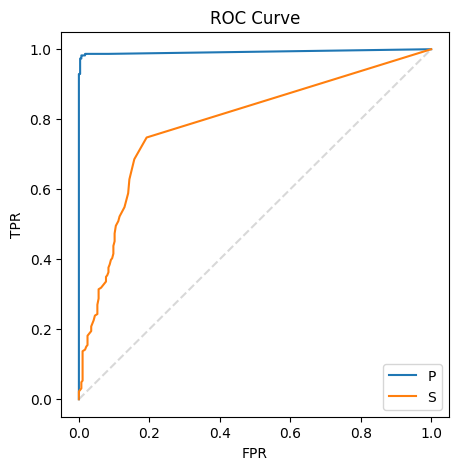

In [11]:
evaluator.roc_curve()

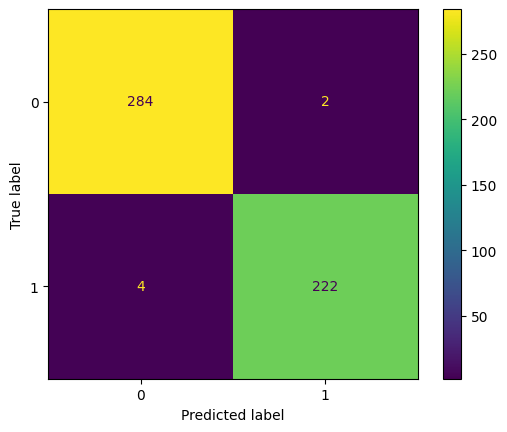

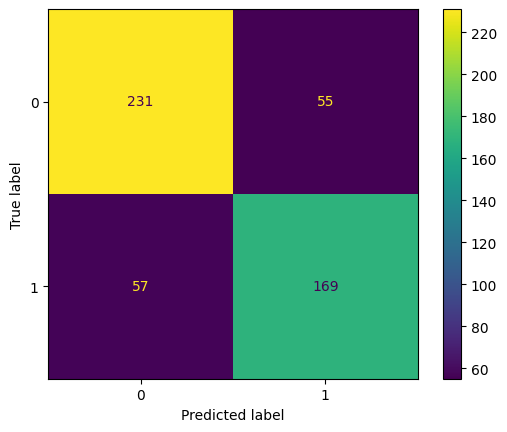

In [13]:
evaluator.plot_confusion_matrix()

/Users/rob/Documents/GitHub/earthquake-monitoring/classification/eval_utils.py:155: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


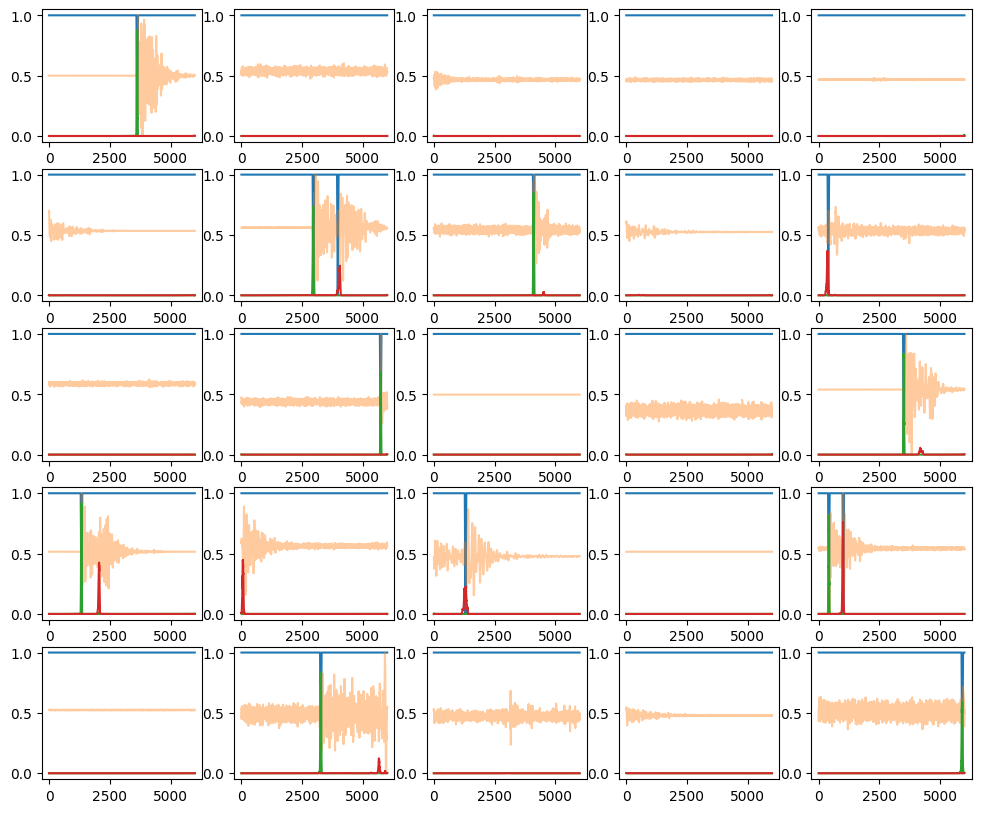

In [12]:
evaluator.plot_preds(5, offset=10)

In [17]:
num_batches = 8
cl = 136
num_waves = batch_size * num_batches
nlength = 6000 #- cl

raw_wave = torch.empty(num_waves, nlength)
raw_labels = torch.empty(num_waves, 3, nlength)
preds = torch.empty(num_waves, 3, nlength)

model.to('cpu')
# Predicting on validation data
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        if i == num_batches: break
        raw_wave[batch_size*i:batch_size*(i+1)] = inputs[:, 0, :]
        raw_labels[batch_size*i:batch_size*(i+1)] = labels
        preds[batch_size*i:batch_size*(i+1)] = model(inputs, logits=False)# #robertmodel(inputs.unsqueeze(1))) <- Depending on model one should work

In [18]:
# Transformations on predictions later used for some metrics
preds_maxs = (preds.max(axis = 2))[0]
lmax, largmax = raw_labels.max(axis=2)
noise_mask = largmax[:, 0] == 0

preds_maxs_eq = preds_maxs[~noise_mask][:, 0:2]
preds_maxs_noise = preds_maxs[noise_mask][:, 0:2]

theta_p = eval_utils.best_threshold(preds_maxs_eq[:, 0], preds_maxs_noise[:, 0])
theta_s = eval_utils.best_threshold(preds_maxs_eq[:, 1], preds_maxs_noise[:, 1])

# More transformations needed for "within range ROC curve" plot
picks = largmax[:, 0:2]
preds_pick = (preds.max(axis = 2))[1]

p_preds_eq = preds[:, 0, :][~noise_mask]
p_preds_noise = preds[:, 0, :][noise_mask]

s_preds_eq = preds[:, 1, :][~noise_mask]
s_preds_noise = preds[:, 1, :][noise_mask]

### Eval stuff ---

In [19]:
eval_utils.f1score(preds_maxs_eq[:, 0], preds_maxs_noise[:, 0], theta_p), eval_utils.f1score(preds_maxs_eq[:, 1], preds_maxs_noise[:, 1], theta_s)

(tensor(0.9883), tensor(0.9248))

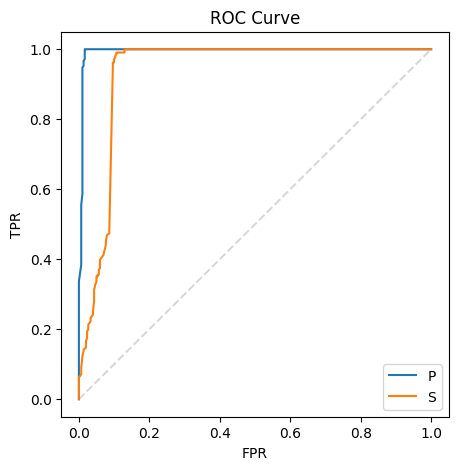

In [20]:
eval_utils.roc_curve(preds_maxs_eq, preds_maxs_noise)

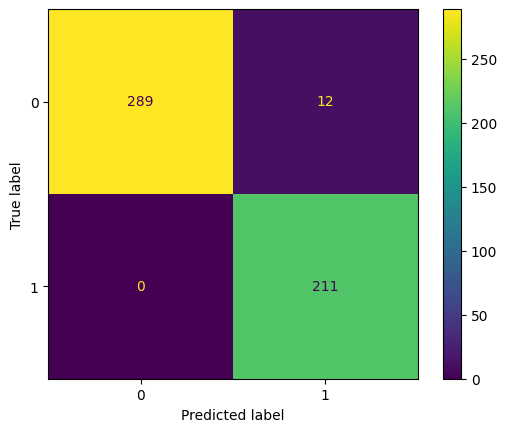

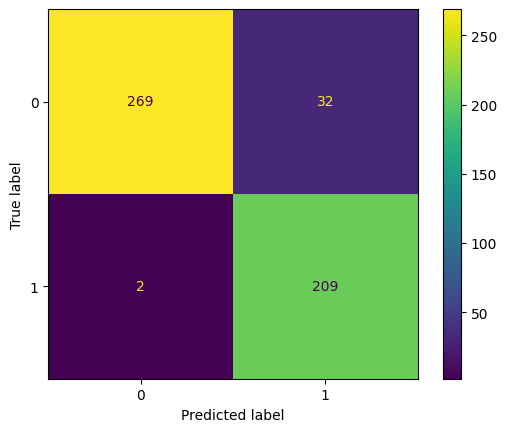

In [21]:
eval_utils.plot_confusion_matrix(preds_maxs_eq, preds_maxs_noise, theta_s)


In [15]:
def plot_preds(model, val_loader, num_plots=10):
    batch_num = 2
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))

            fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Create 2 subplots

            # Plot on the first subplot
            axs[0].plot(labels.cpu().detach().numpy()[i, 2])
            axs[0].plot(inputs.cpu().detach().numpy()[i, 0])
            axs[0].plot(outputs.cpu().detach().numpy()[i,0,:])
            axs[0].plot(outputs.cpu().detach().numpy()[i,1,:])

            plt.show()
            if (i == num_plots): break

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_71000/2715190771.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


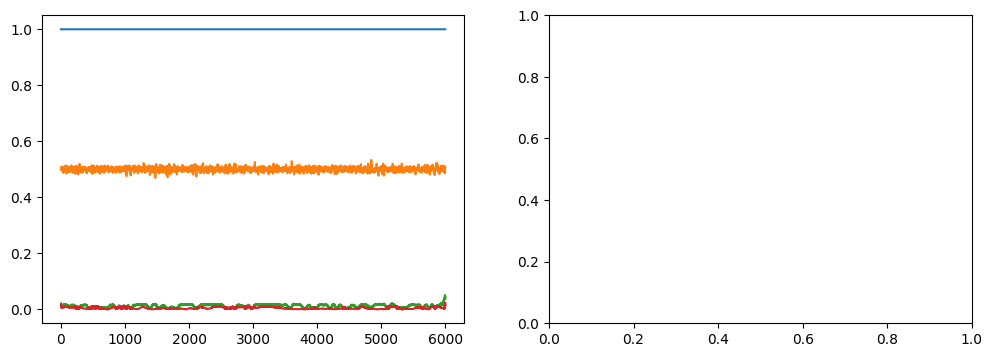

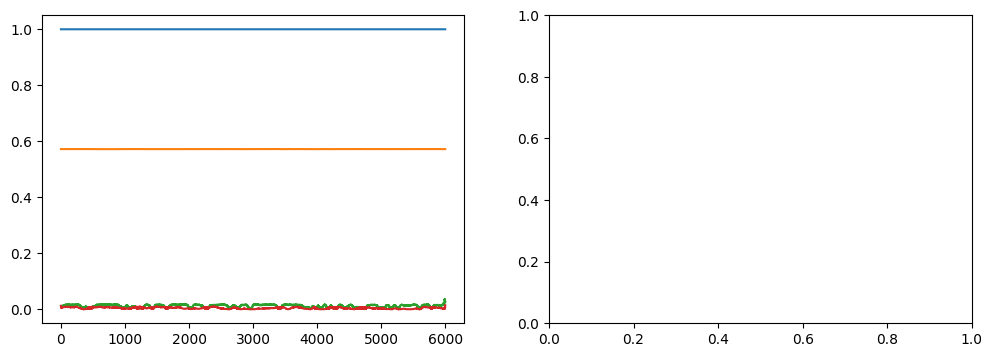

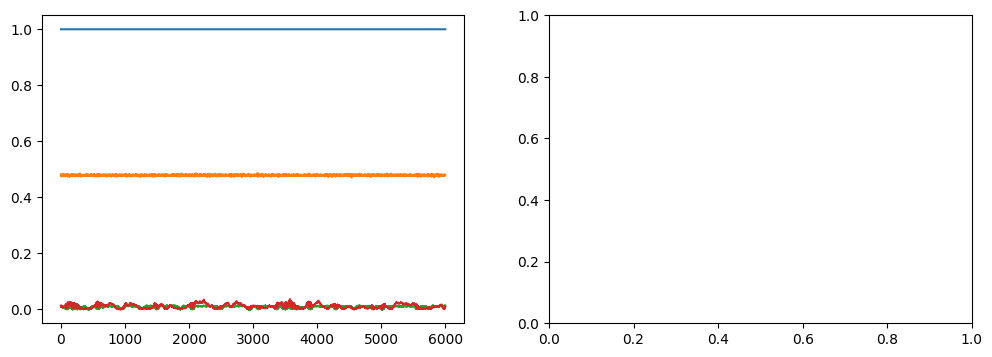

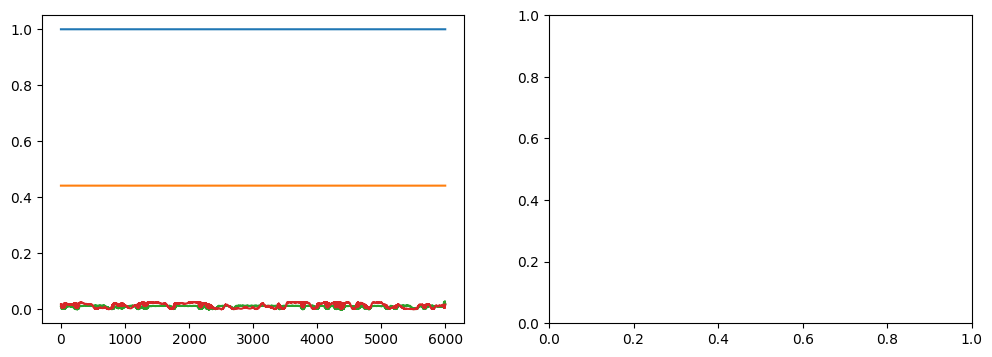

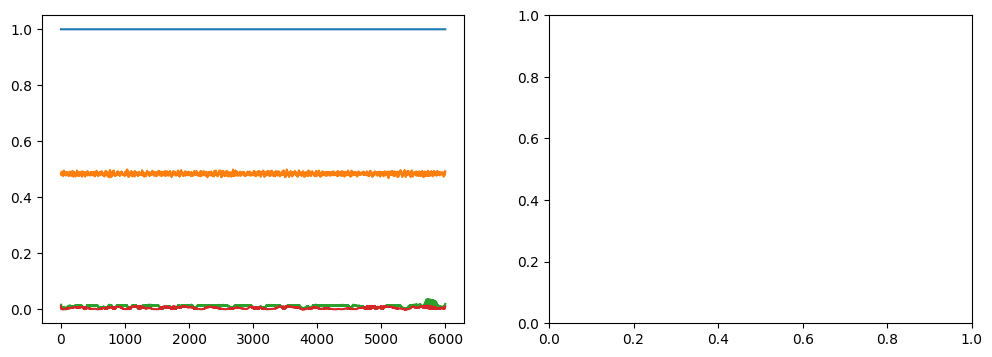

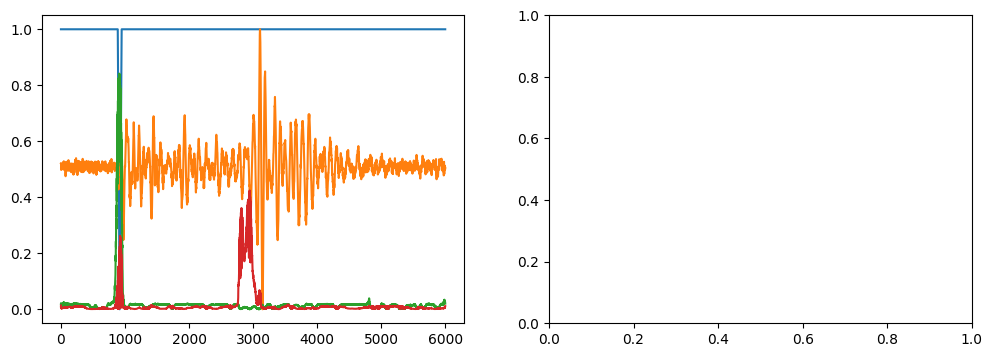

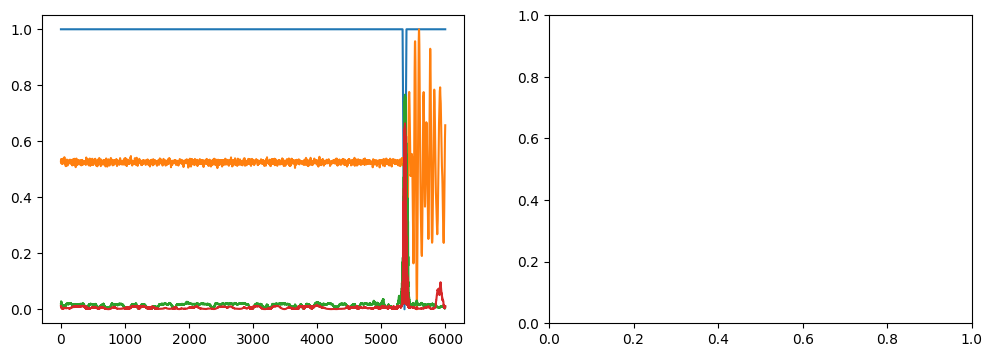

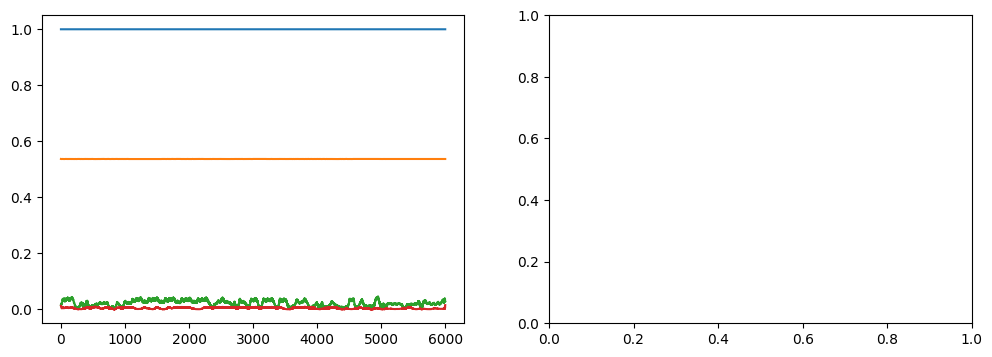

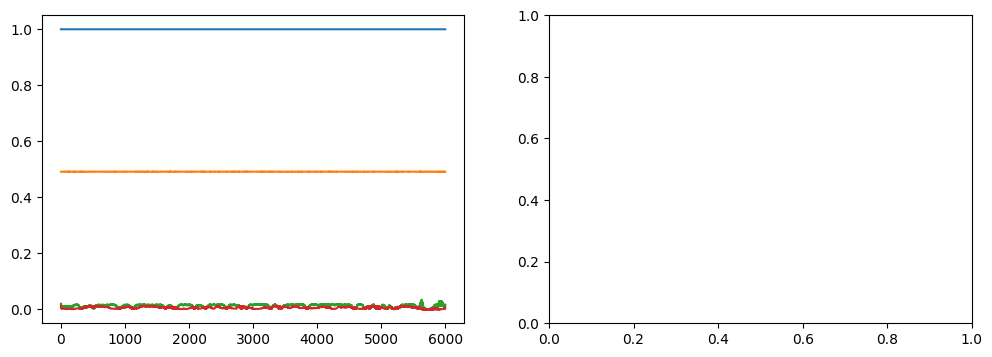

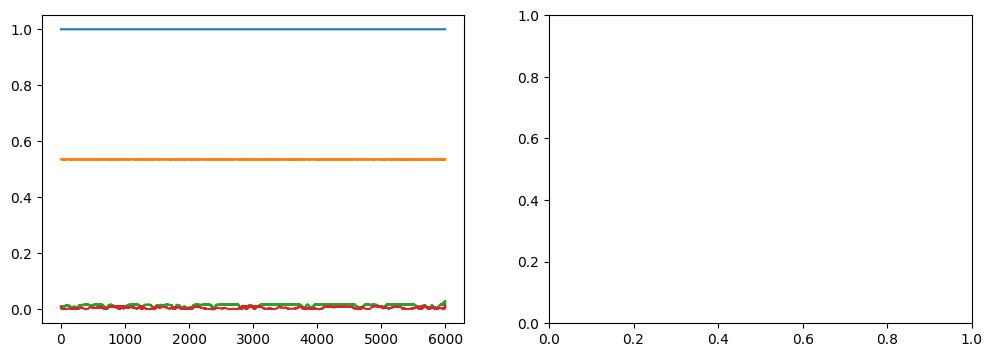

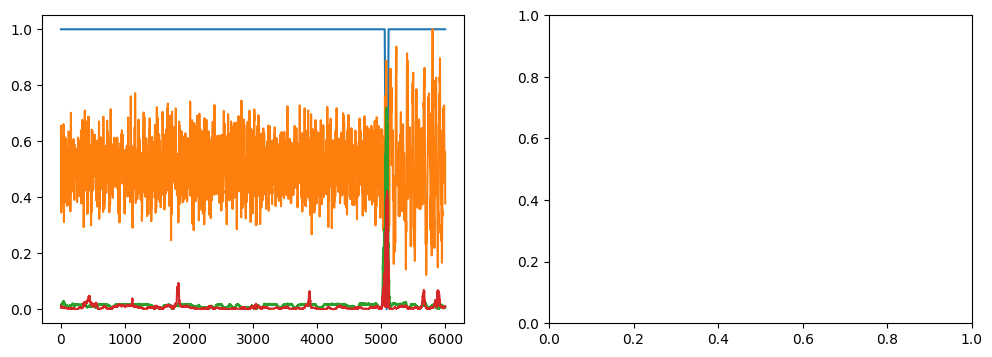

In [16]:
model.to(device)
plot_preds(model, val_loader)

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_54859/2715190771.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


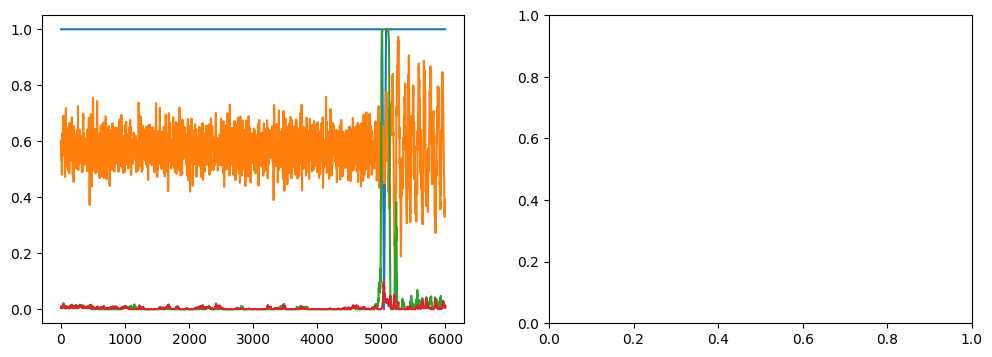

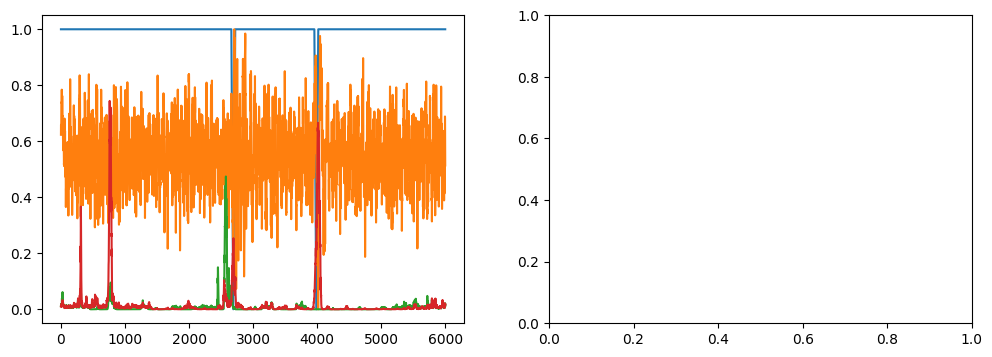

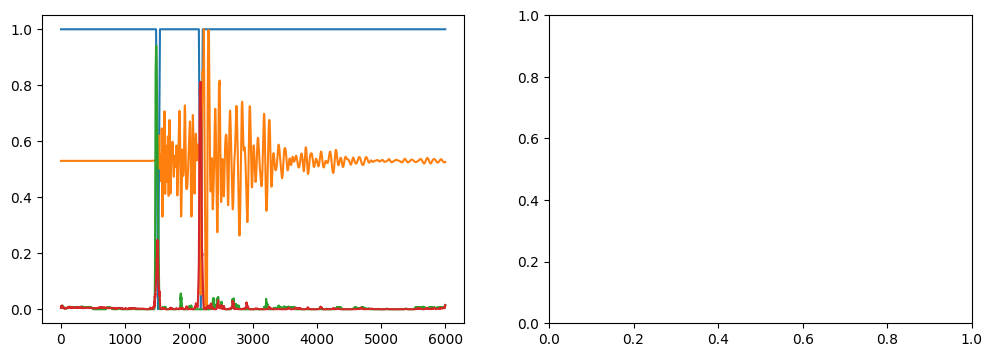

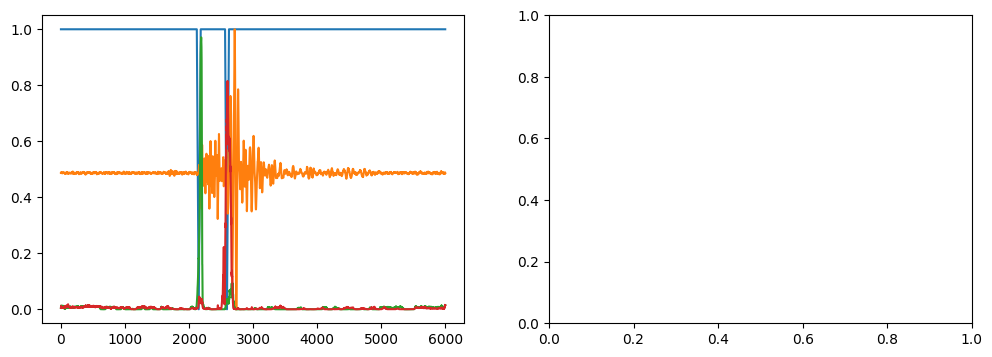

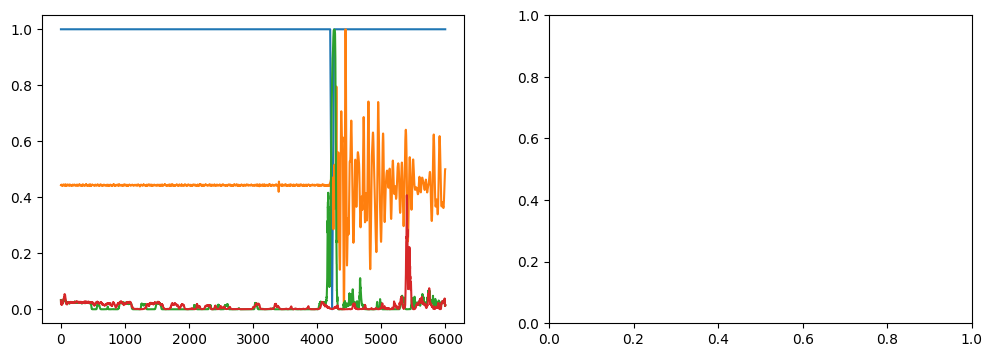

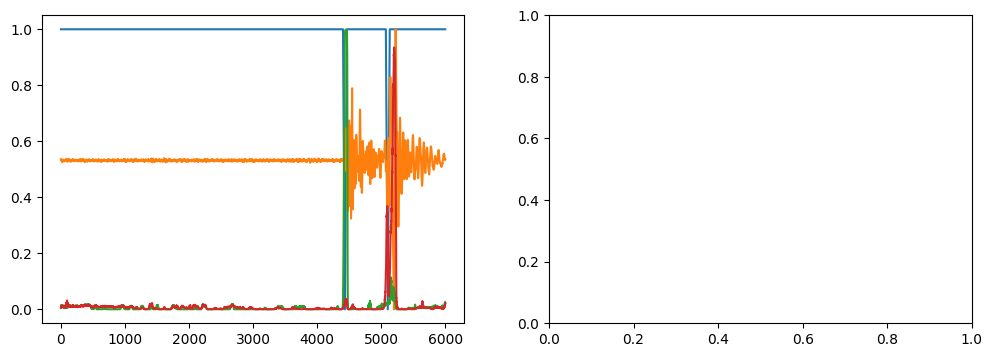

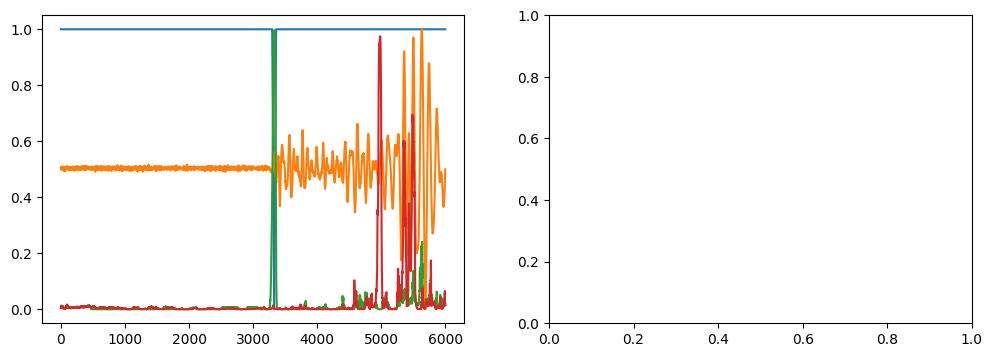

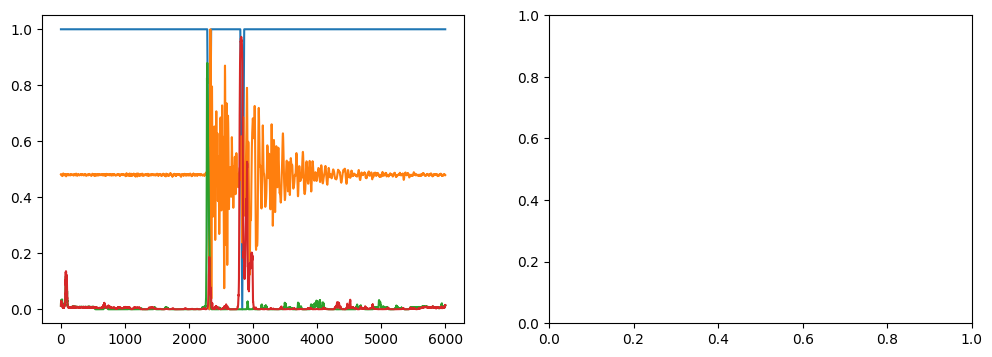

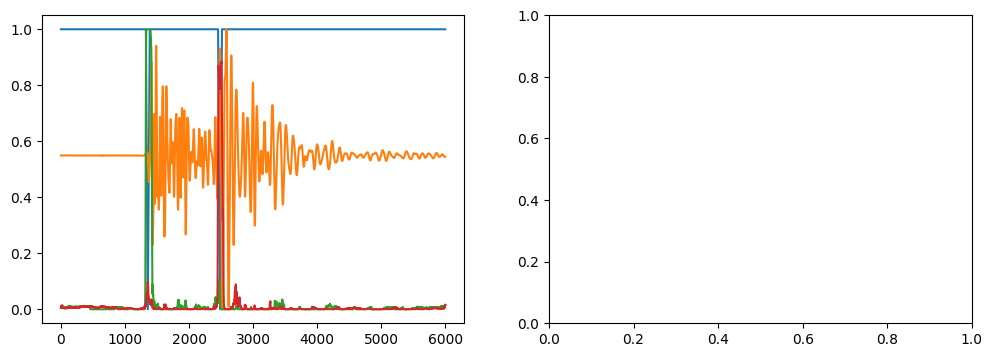

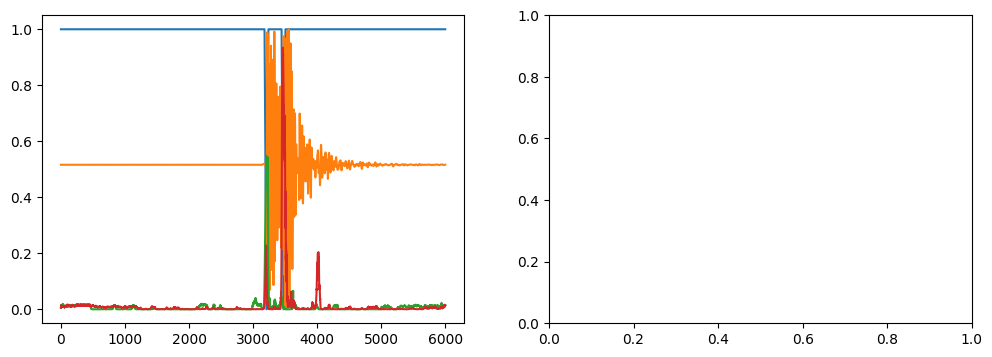

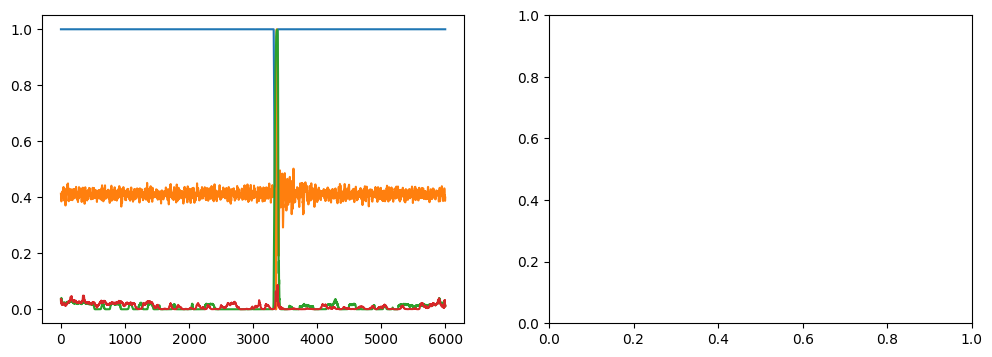

In [19]:
# 100 epochs, 0.003 lr, fully unpunished for singles
plot_preds(model, val_loader)

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_49423/2715190771.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


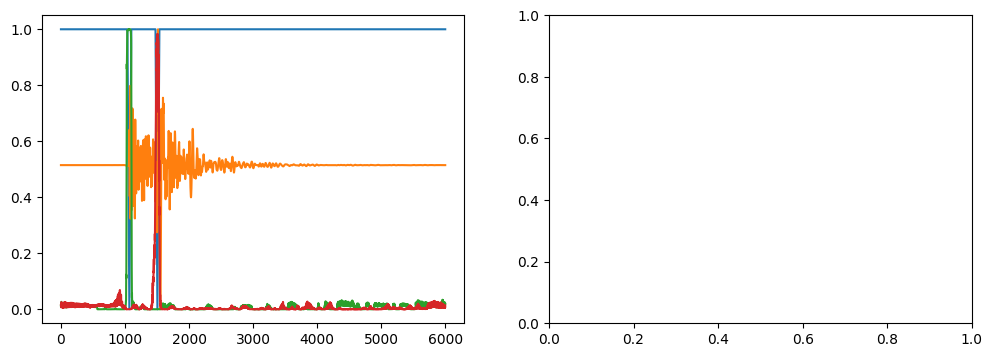

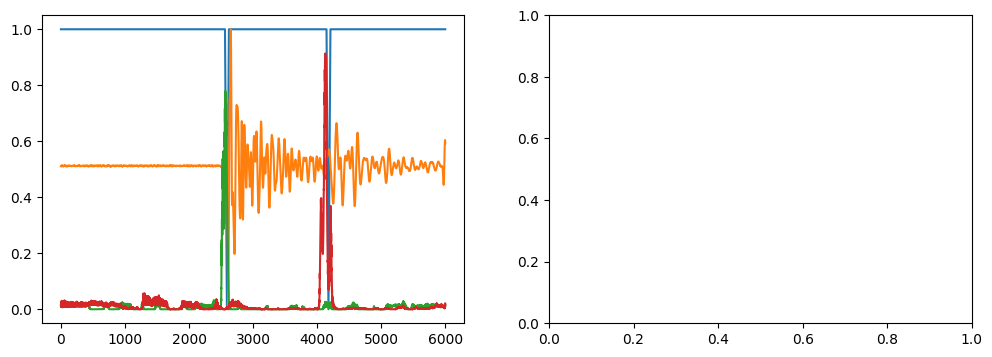

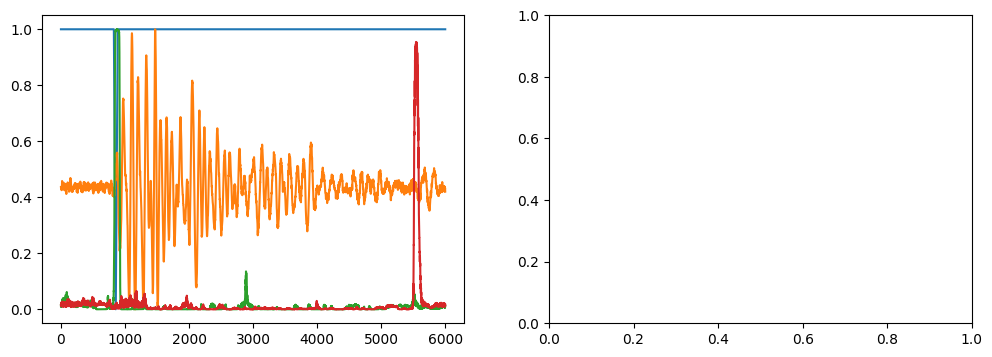

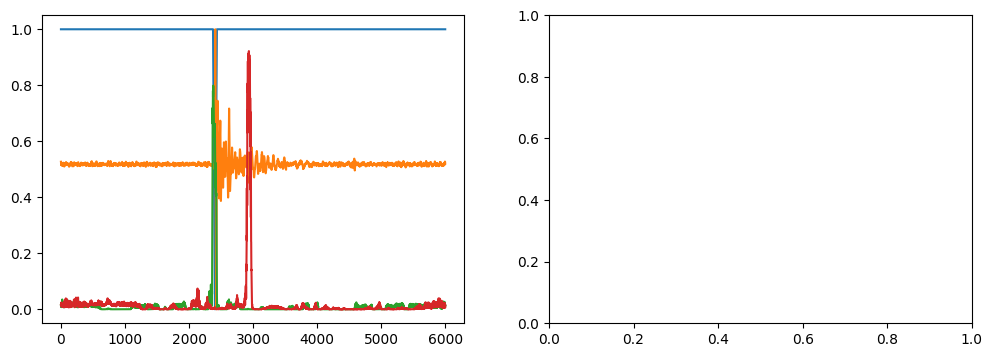

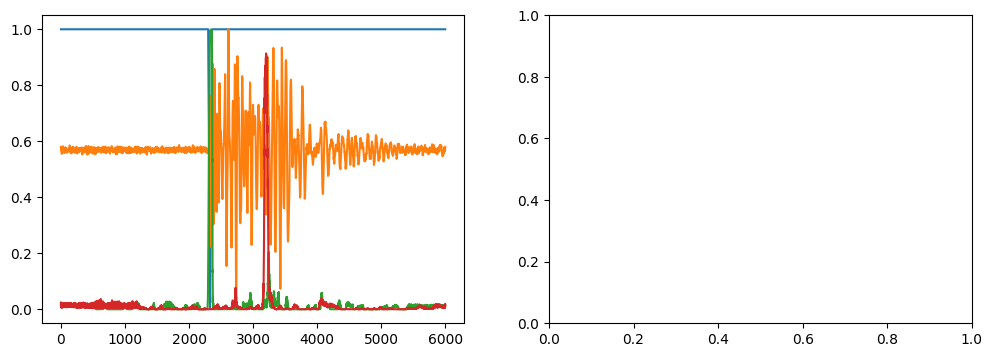

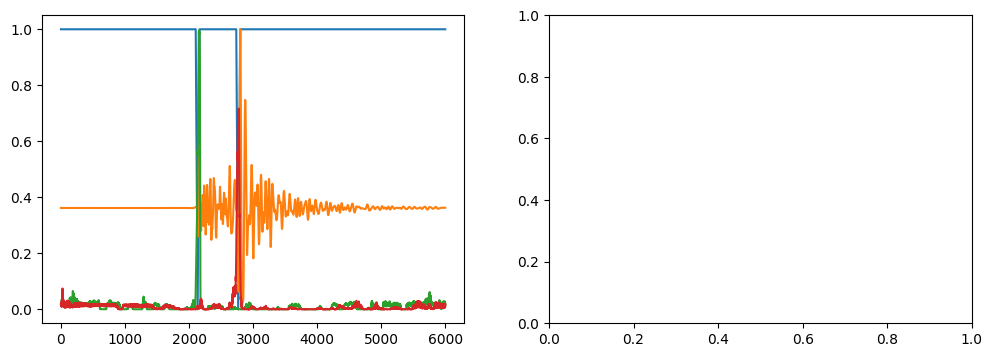

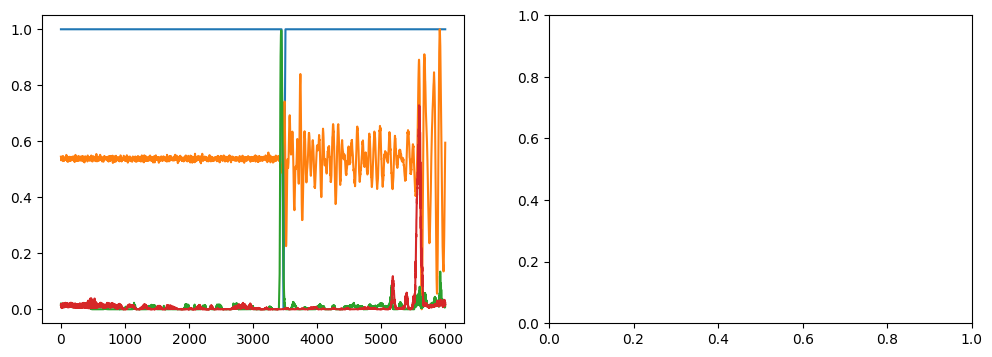

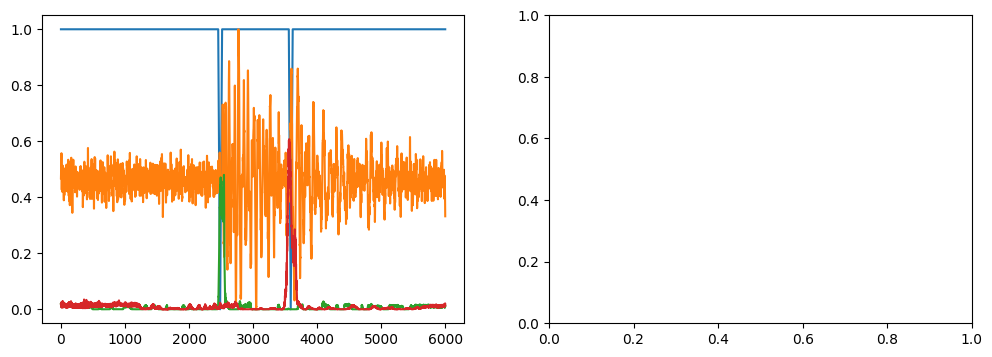

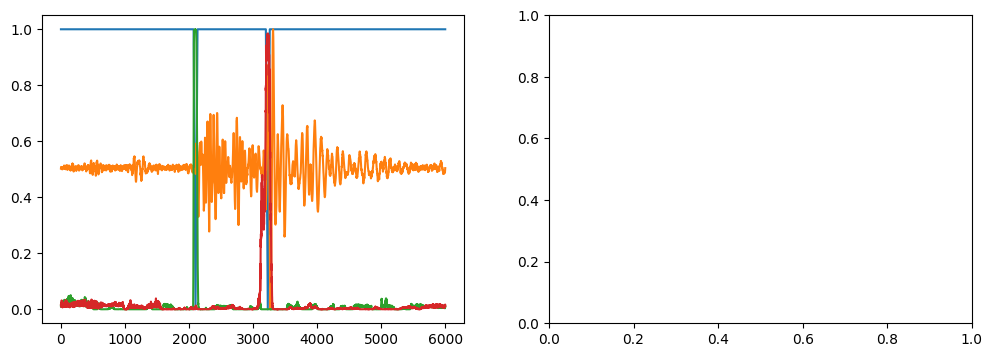

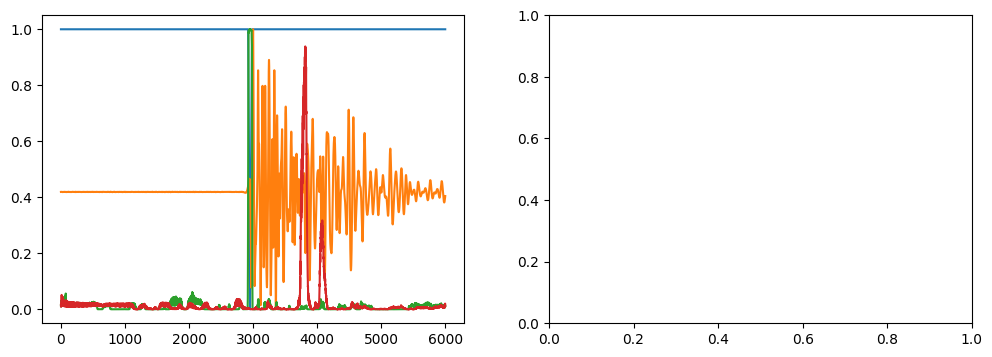

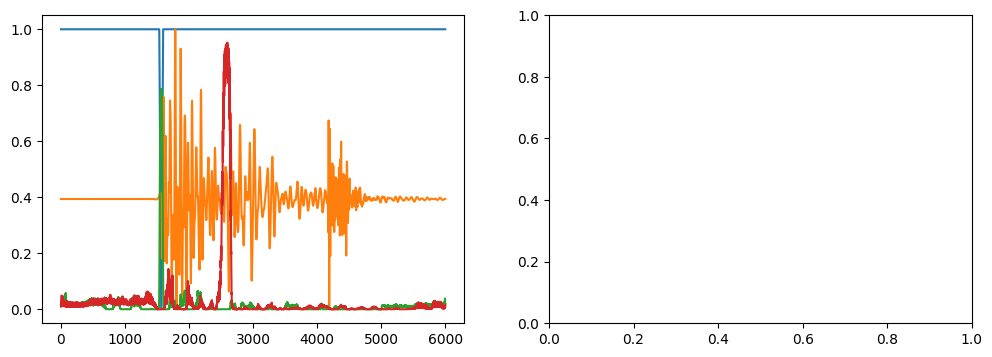

In [20]:
# 50 epochs, 0.001 lr, not punishing s wave on only p labels
plot_preds(model, val_loader)

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_49423/2715190771.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


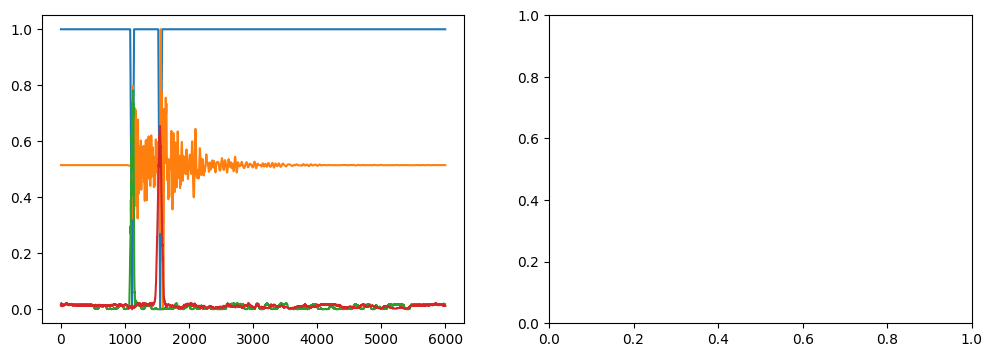

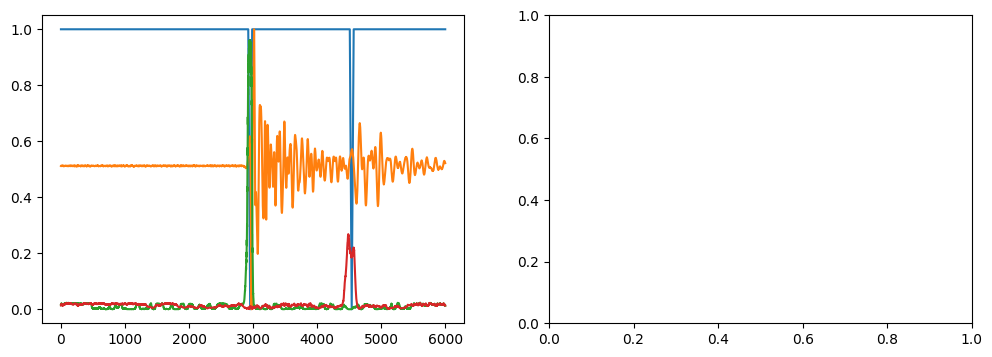

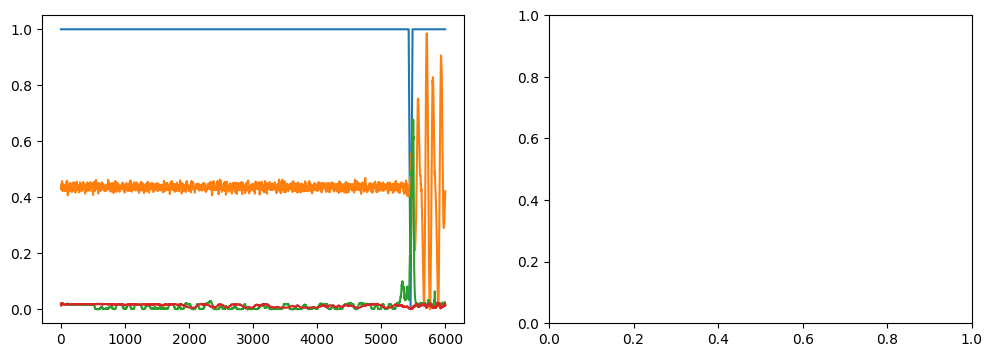

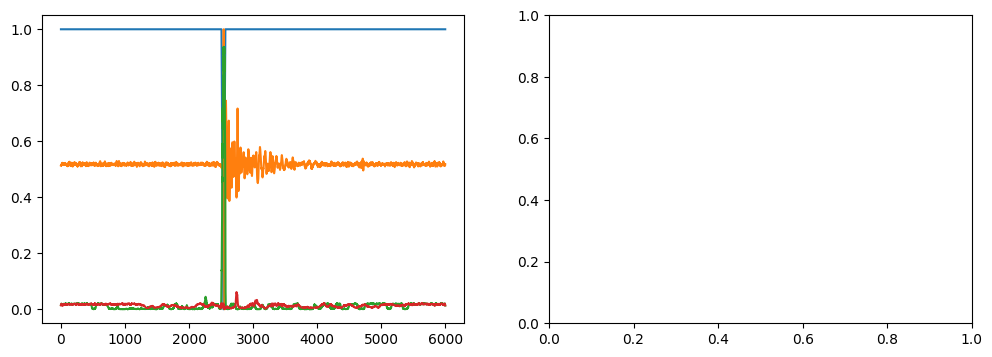

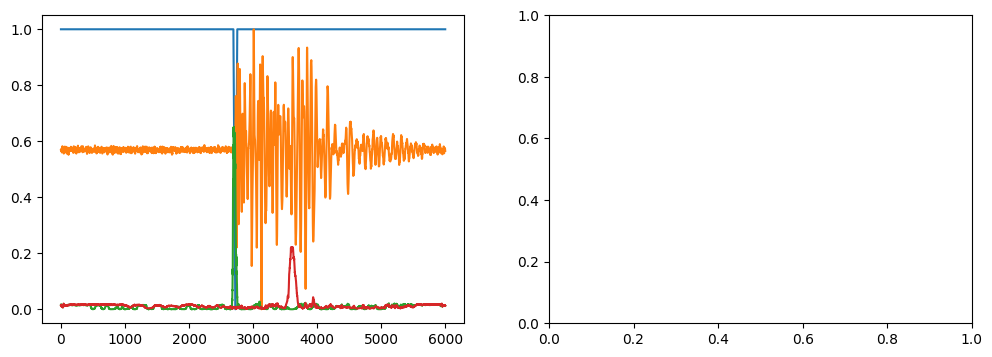

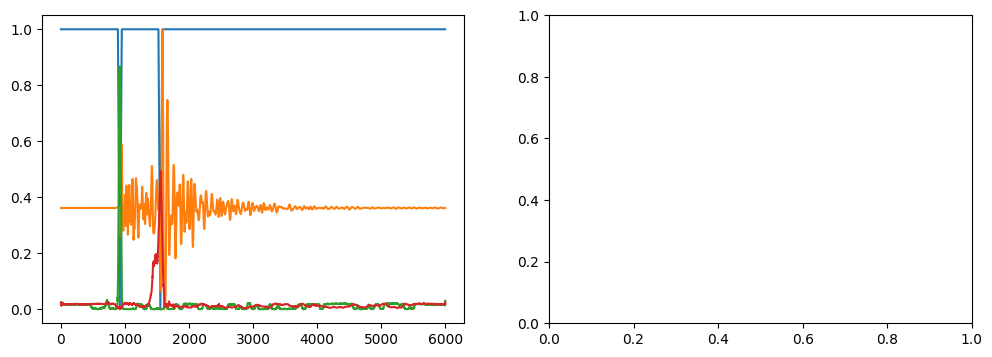

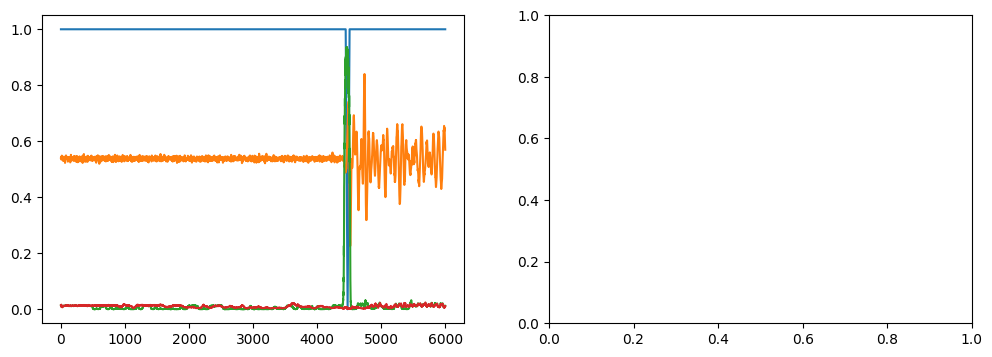

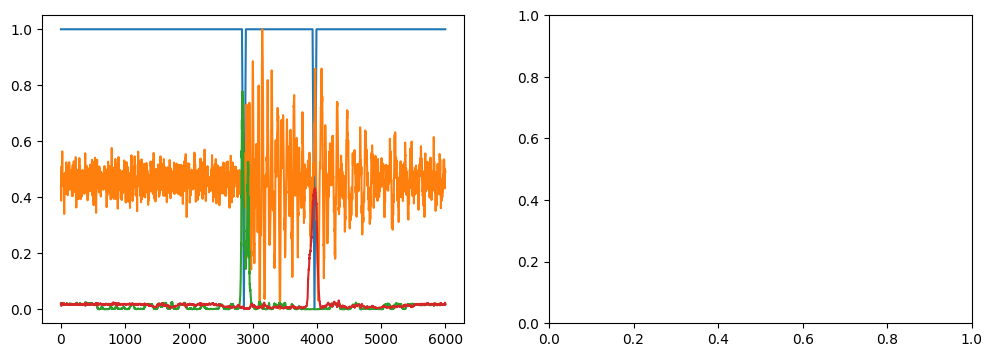

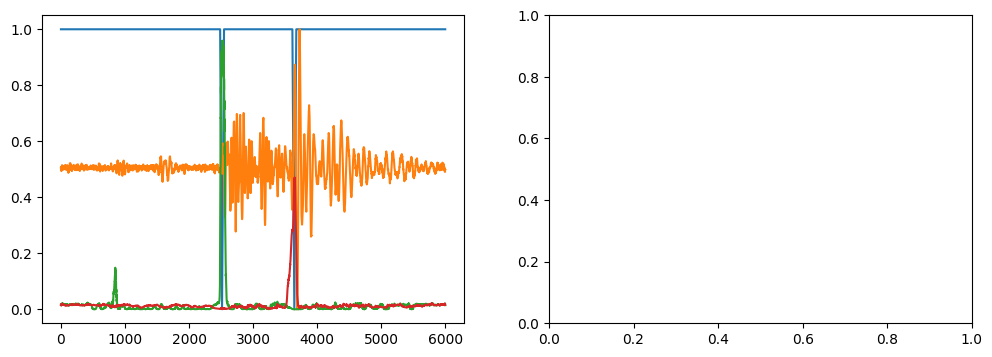

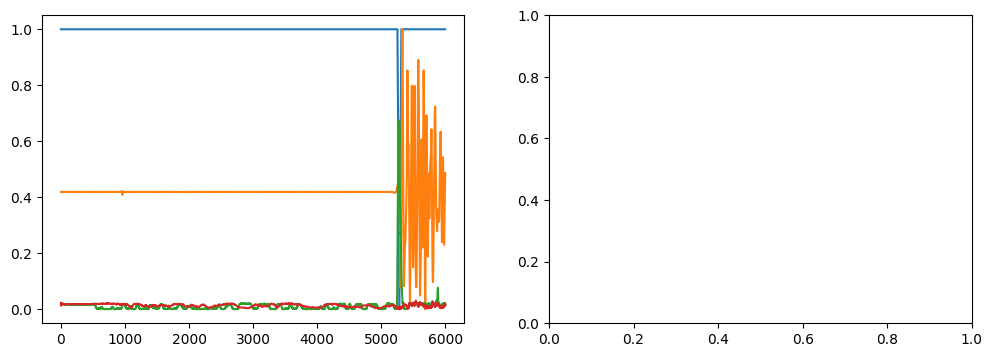

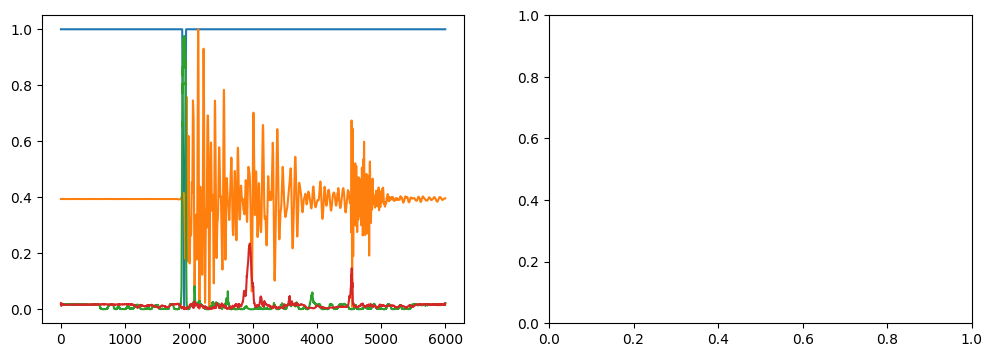

In [7]:
# 50 epochs 0.001 lr, with p's as well, but punished s in training
plot_preds(model, val_loader)

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_43101/2715190771.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


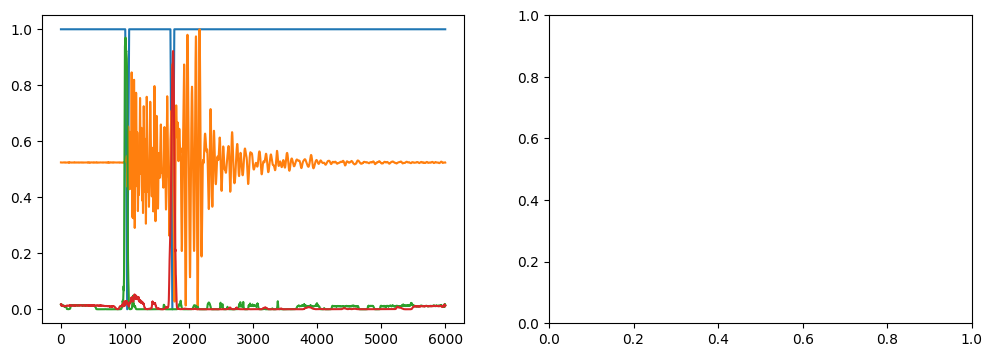

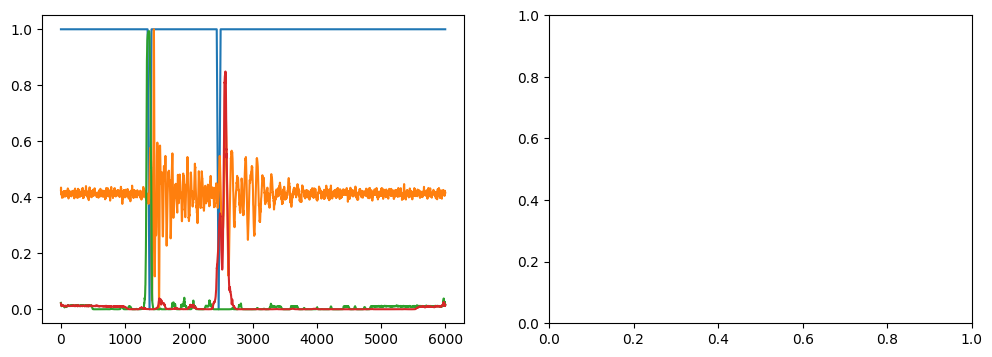

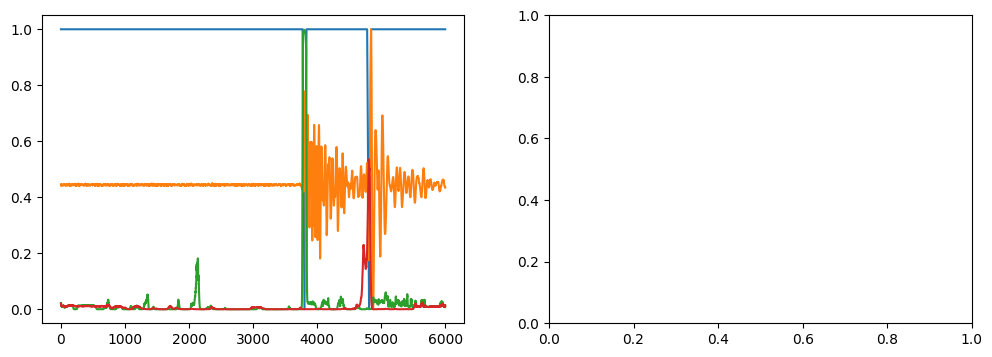

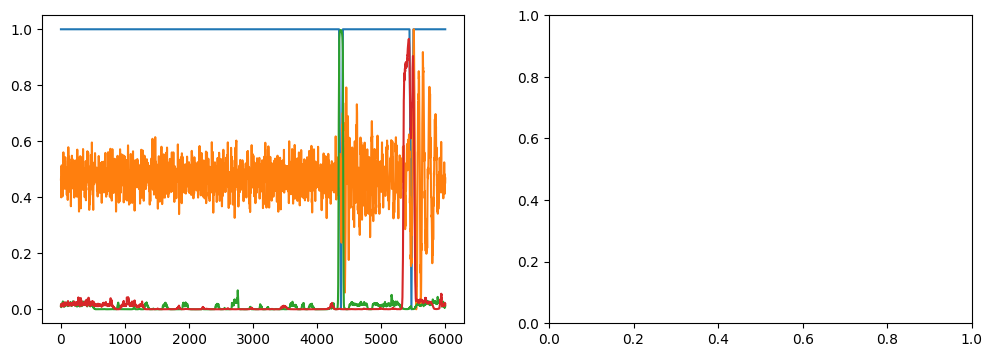

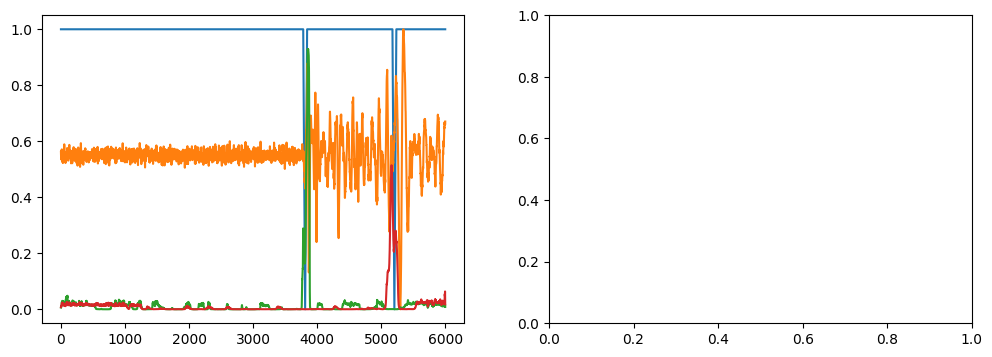

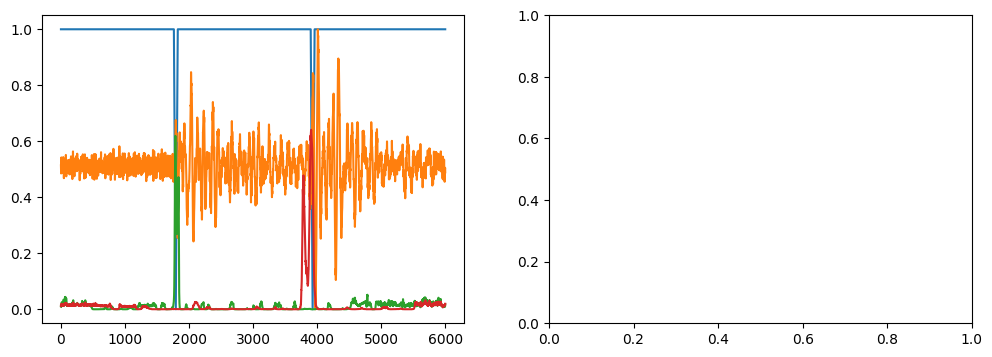

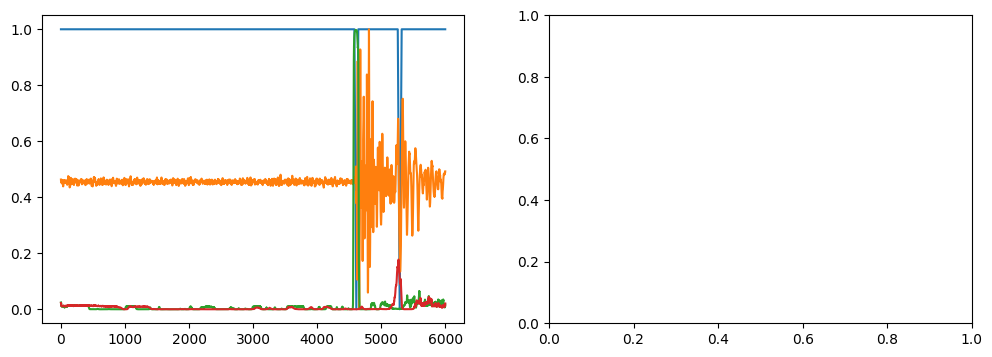

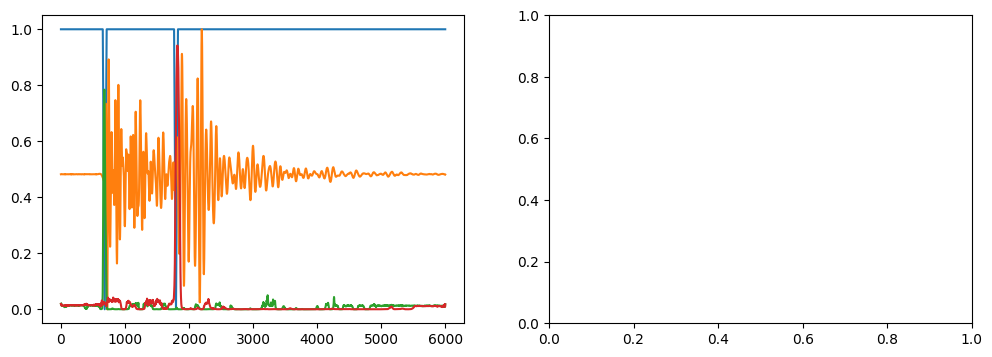

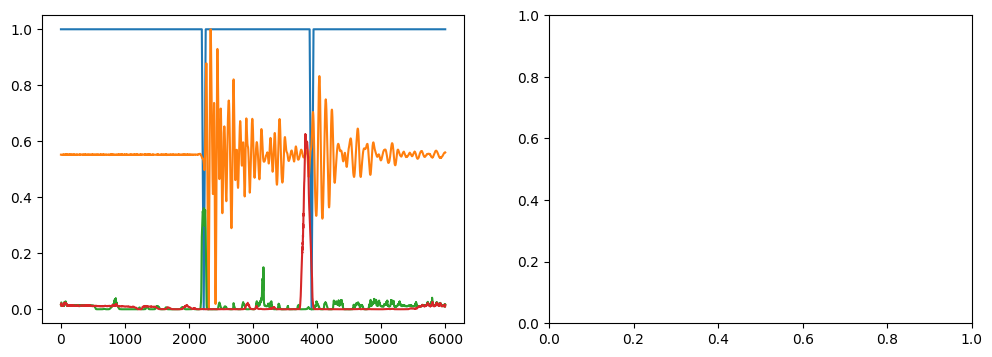

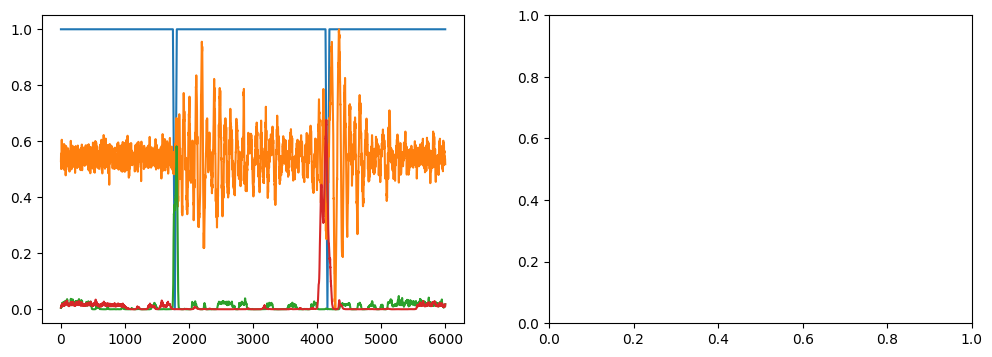

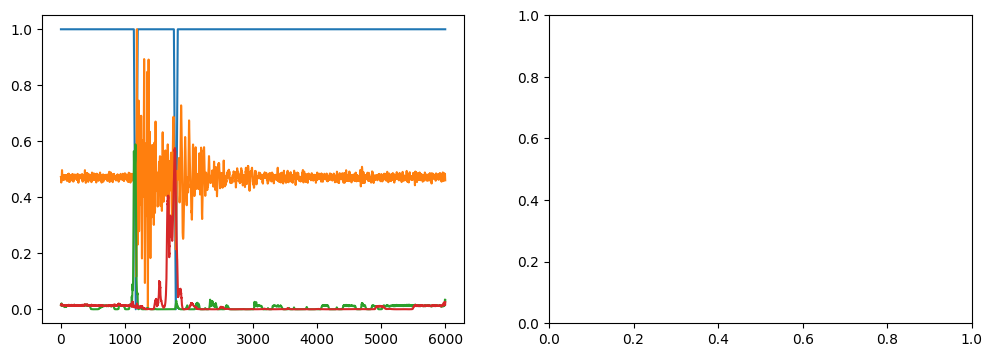

In [20]:
# 50 epochs 0.01 lr
plot_preds(model, val_loader)

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_43101/2715190771.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


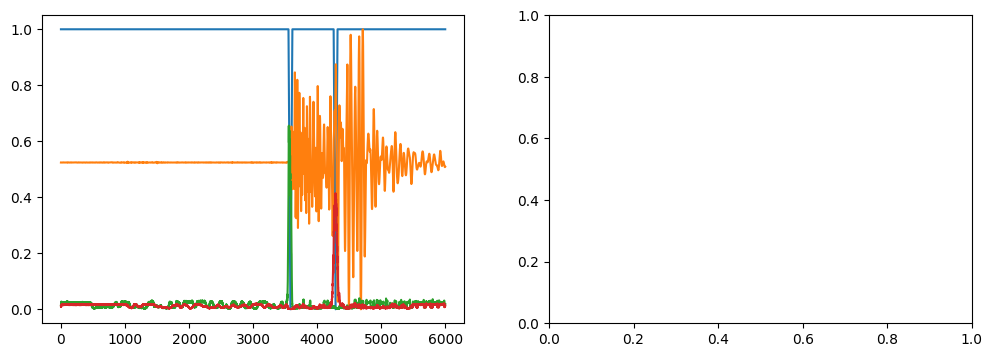

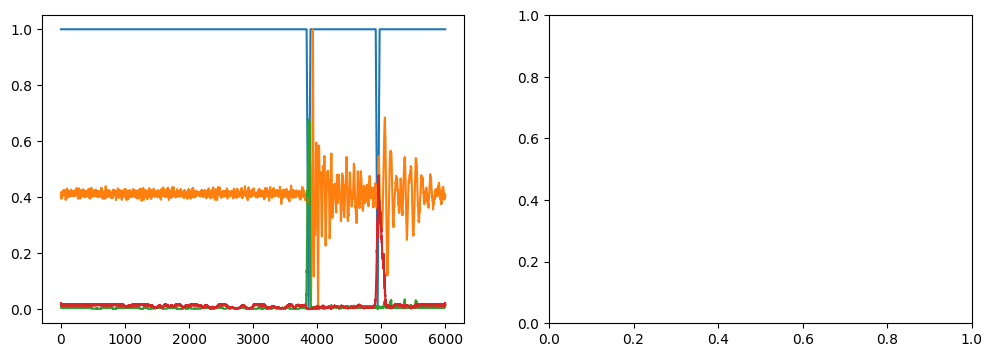

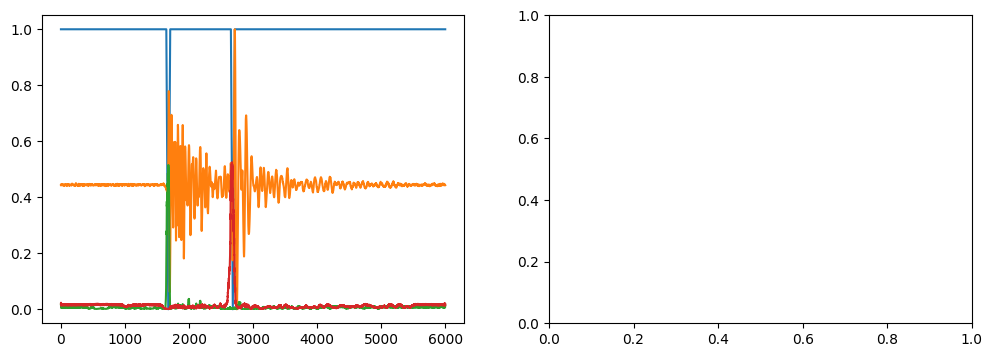

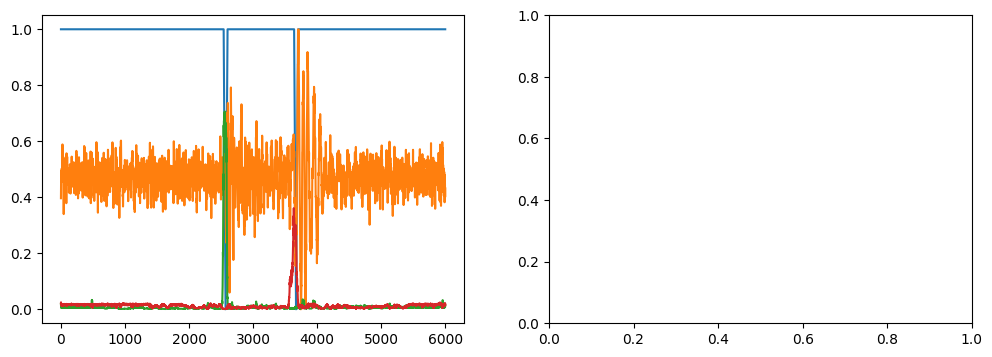

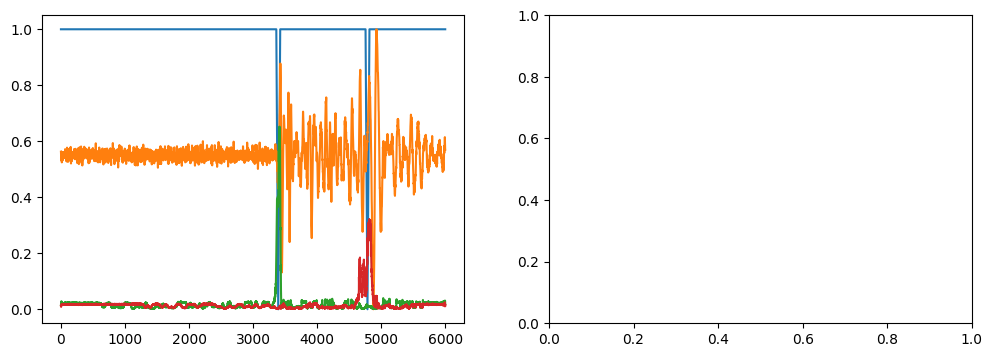

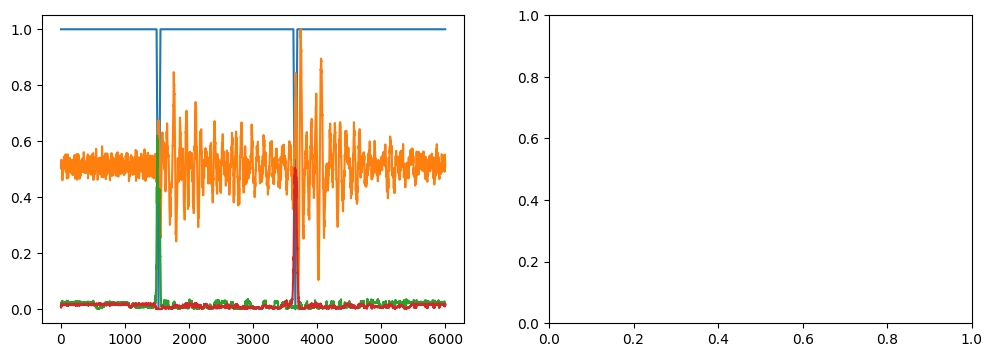

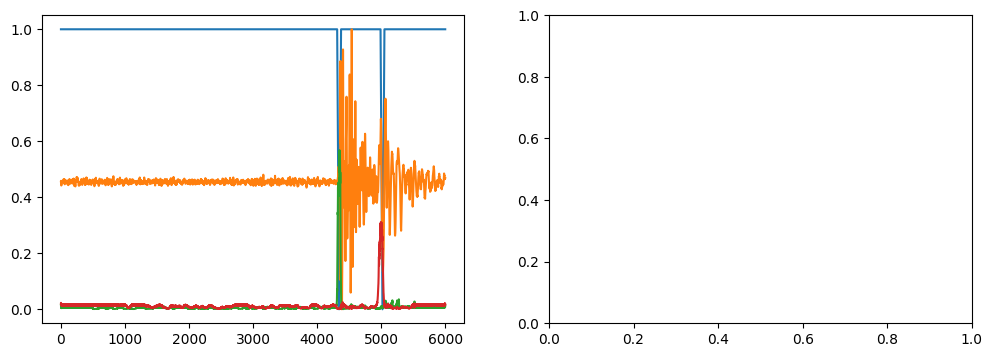

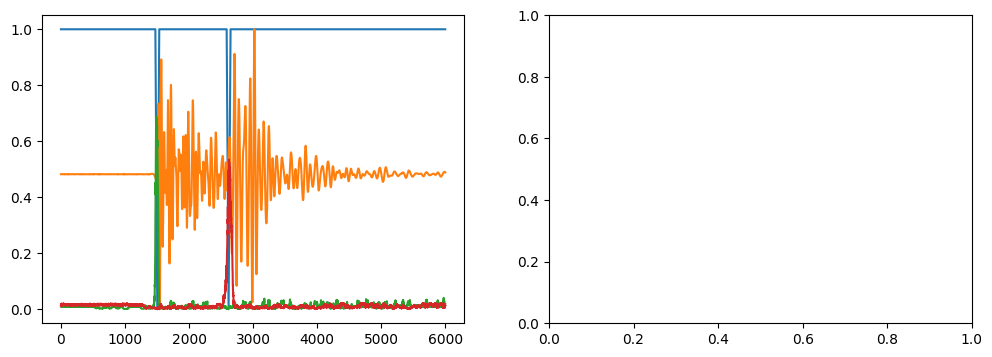

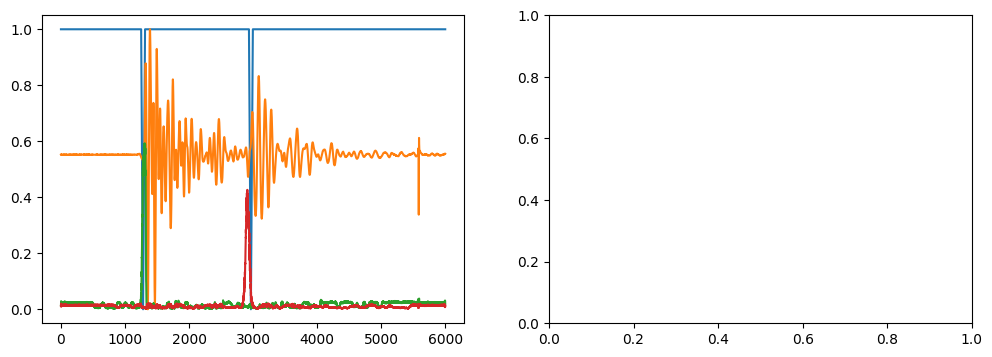

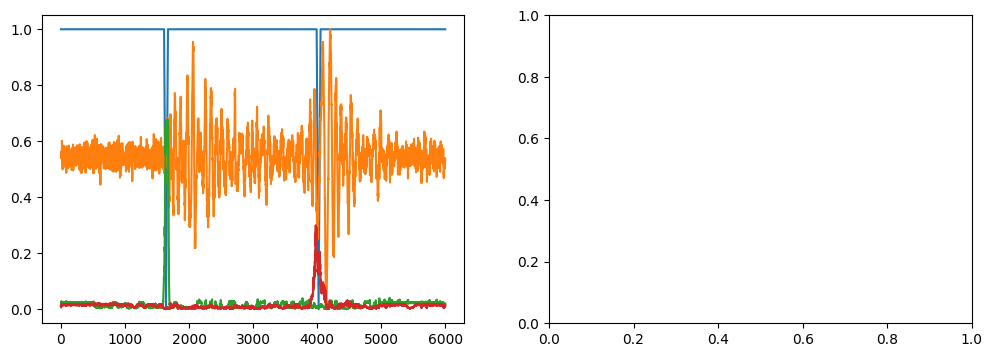

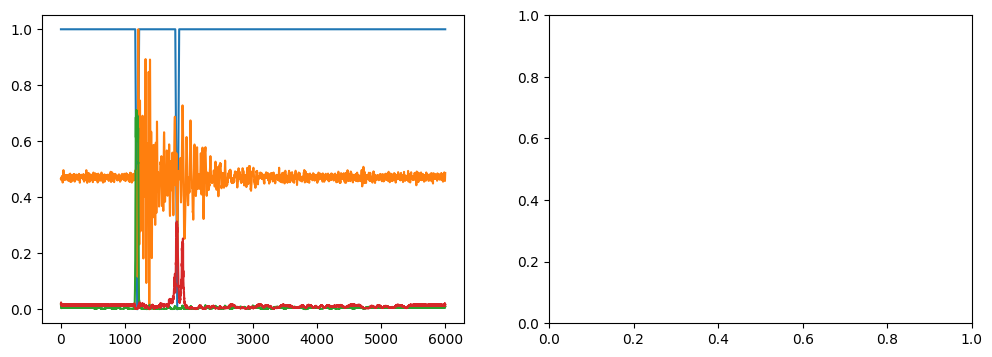

In [8]:
# 30 epochs lr=0.001
plot_preds(model, val_loader)

/var/folders/jp/cc_r_y3x6clgl7b4rwk3lgfw0000gn/T/ipykernel_18405/930797250.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


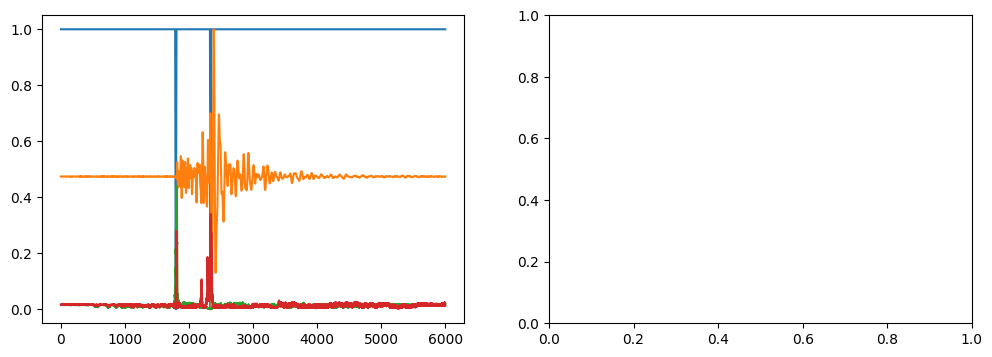

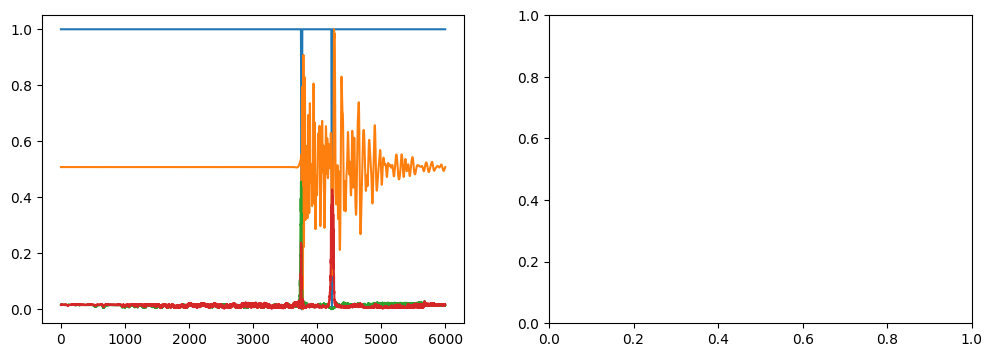

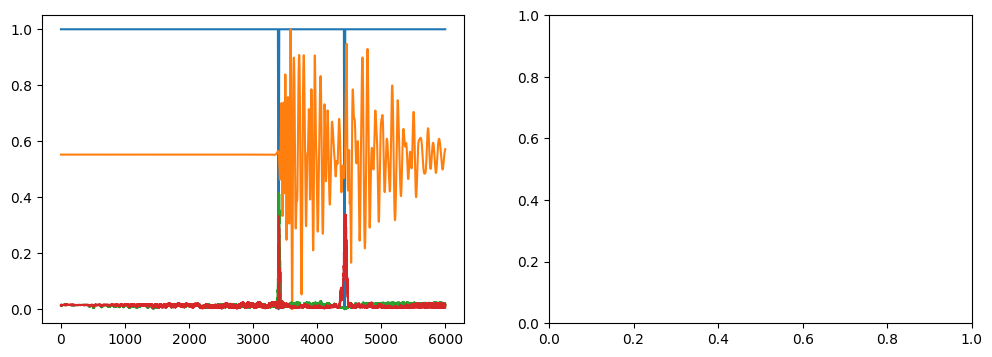

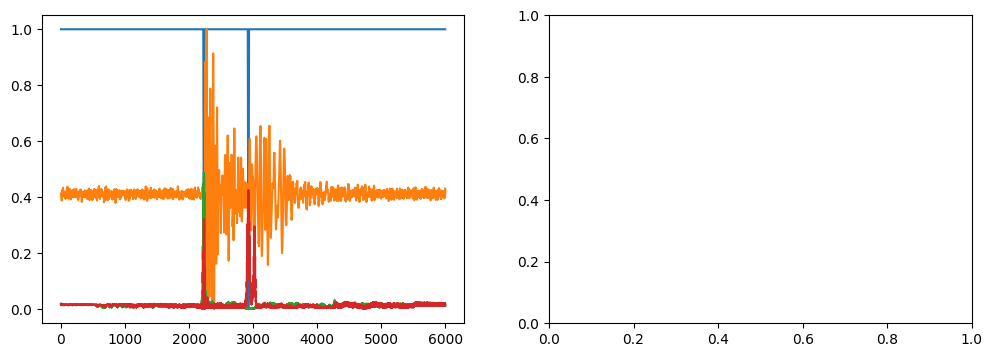

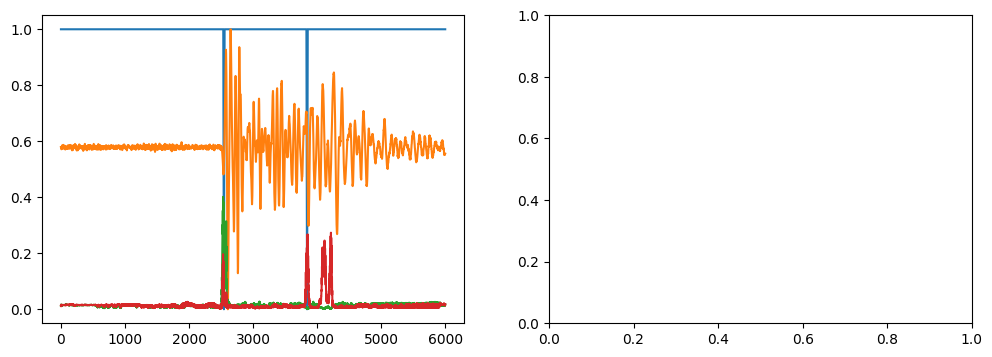

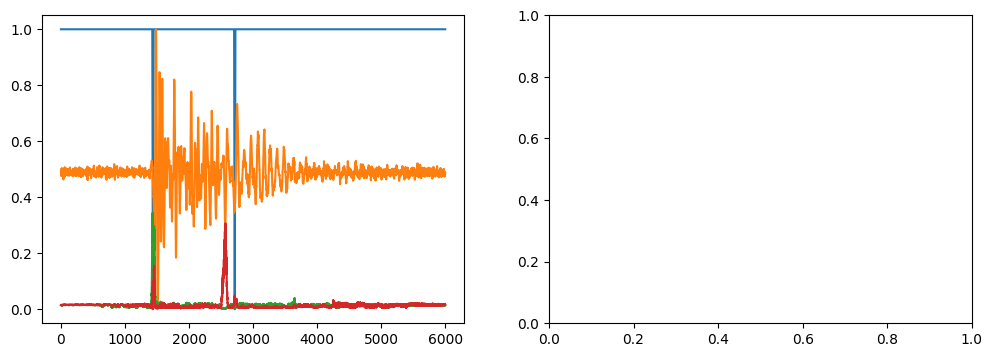

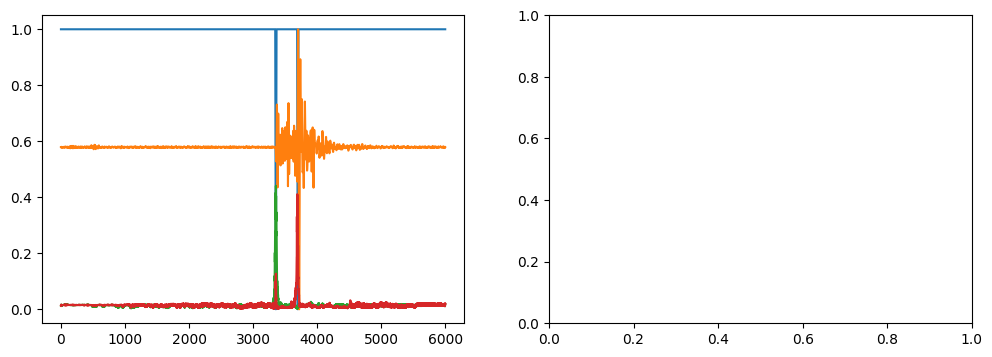

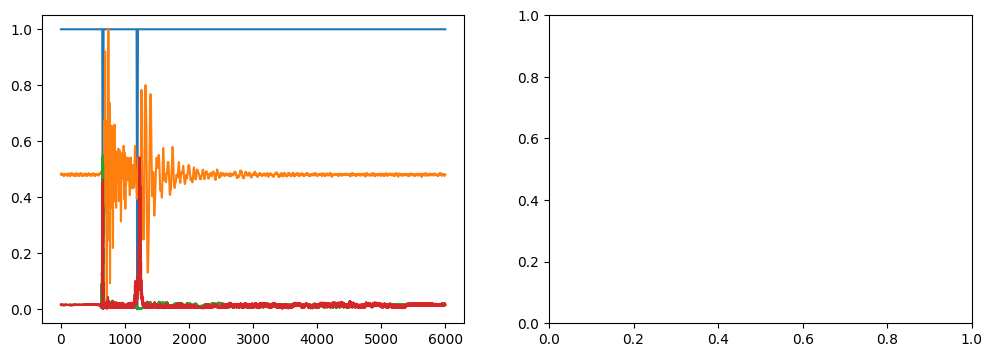

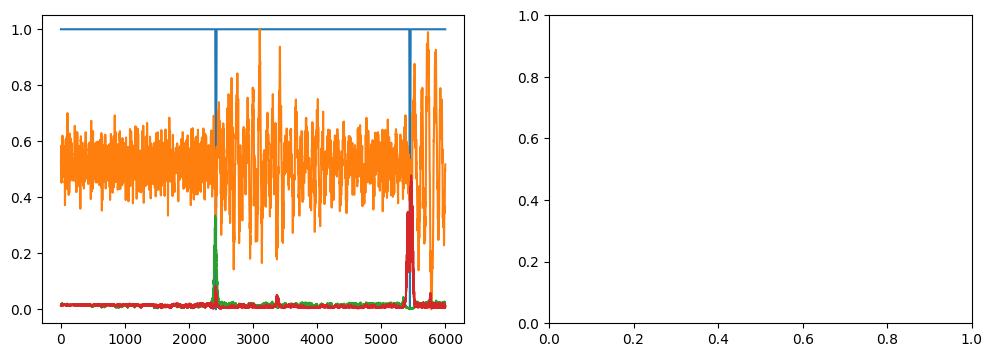

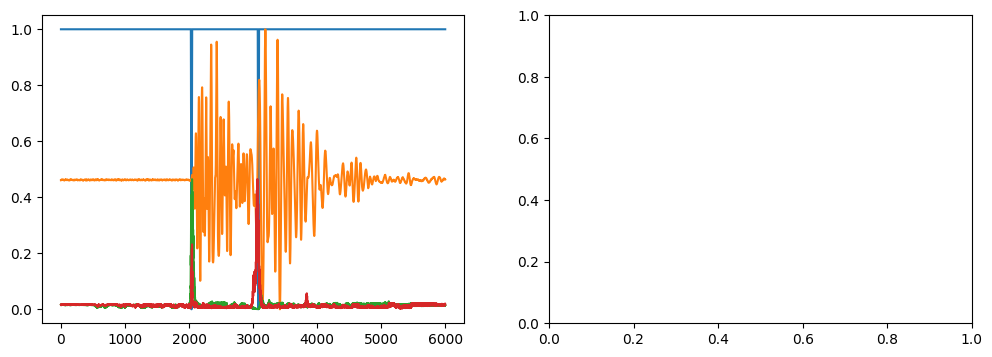

In [10]:
import seisbench.models as sbm 
import sys 
sys.path.append("..")
from models.PhaseNet import PhaseNet
"""pnet_pretrained = sbm.PhaseNet.from_pretrained('original')
# Assuming pnet_pretrained is your pretrained model and inc is the first Conv1d layer

# Get the weights from the first channel of the pretrained layer
weights = pnet_pretrained.inc.weight.data[:, 0:1, :]

# Create a new Conv1d layer with a single input channel
new_layer = torch.nn.Conv1d(1, pnet_pretrained.inc.out_channels, pnet_pretrained.inc.kernel_size[0])

# Set the weights of the new layer
new_layer.weight.data = weights

# Replace the first Conv1d layer in the pretrained model with the new layer
pnet_pretrained.inc = new_layer

# our own model trained on STEAD
pnet_stead = torch.load("..\\classification_tolga\\phasenet_15epochs.pt")"""